# Random Forest


In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [2]:
X_train = pd.read_csv("../../data/X_train.csv", index_col=0)
y_train = pd.read_csv("../../data/y_train.csv", index_col=0)
X_test = pd.read_csv("../../data/X_test.csv", index_col=0)
y_test = pd.read_csv("../../data/y_test.csv", index_col=0)

## Hyperparameter tuning



In [3]:
def hyperparameter_tuning(X_train, X_test, y_train, y_test, function, param_grid, scoring, cv):
    mod_cv = sklearn.model_selection.RandomizedSearchCV(function, n_iter=50, param_distributions=param_grid, scoring=scoring, cv=cv)
    
    mod_cv.fit(X_train, y_train)
    best_param = mod_cv.best_params_
    best_train_score = mod_cv.best_score_
    
    y_pred = mod_cv.predict(X_test)
    
    score_dict = {"Best Hyperparameters": best_param,
                  "Best training score": best_train_score,
                  "Accuracy": sklearn.metrics.accuracy_score(y_test, y_pred), 
                  "F1 score": sklearn.metrics.f1_score(y_test, y_pred),
                  "AUC": sklearn.metrics.roc_auc_score(y_test, y_pred)}
            
    return score_dict, y_pred

In [4]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=1)
param_grid = {"n_estimators": np.arange(10, 100, 15),
              "criterion": ["gini", "entropy"],
              "max_depth": np.arange(1, 20, 2),
              "min_samples_split": np.arange(1, 15, 2),
              "min_samples_leaf": np.arange(1, 15, 2),
              "max_features": ["auto", "log2"],
              "oob_score": [True, False],
              "warm_start": [True, False]}

scores = {}
y_preds = {}

for i in y_train.columns:
    print(f"{i} prediction", "\n")
    
    train = y_train[i]
    test = y_test[i]
    
    score_dict, y_preds[i] = hyperparameter_tuning(X_train, X_test, train, test, function=rf, param_grid=param_grid, scoring="accuracy", cv=5)
    scores[i] = score_dict
    
    print(score_dict, "\n")

Happiness prediction 

{'Best Hyperparameters': {'warm_start': False, 'oob_score': False, 'n_estimators': 85, 'min_samples_split': 11, 'min_samples_leaf': 3, 'max_features': 'auto', 'max_depth': 11, 'criterion': 'entropy'}, 'Best training score': 0.7462409886714727, 'Accuracy': 0.7355848434925865, 'F1 score': 0.7655222790357926, 'AUC': 0.7300108241674138} 

Future prediction 

{'Best Hyperparameters': {'warm_start': True, 'oob_score': False, 'n_estimators': 85, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 13, 'criterion': 'entropy'}, 'Best training score': 0.7083419155509784, 'Accuracy': 0.6861614497528831, 'F1 score': 0.7292110874200426, 'AUC': 0.6770223289684368} 

Hardwork prediction 

{'Best Hyperparameters': {'warm_start': False, 'oob_score': True, 'n_estimators': 85, 'min_samples_split': 9, 'min_samples_leaf': 11, 'max_features': 'log2', 'max_depth': 17, 'criterion': 'entropy'}, 'Best training score': 0.6659114315139032, 'Accuracy': 0.672981

## Model Evaluation

ROC curve and area under the curve visualization. Recall, Precision, Specificity, and F1 Score. Recognize that this model is being used to predict the above very happy, optimistic about the future, and the importance of hardwork so precision and recall may be important metrics to pay attention to. 

In [5]:
feature_importance = pd.DataFrame(X_train.columns, columns=["Features"])

for i in scores:
    rf.set_params(**scores[i]["Best Hyperparameters"])
    rf.fit(X_train, train)
    fi = pd.DataFrame(rf.feature_importances_, columns=[i])
    
    feature_importance = pd.concat([feature_importance, fi], axis=1)
    
feature_importance.sort_values("Happiness", ascending=False).head(10)

,Features,Happiness,Future,Hardwork
1,FSscore,0.079065,0.079065,0.088022
0,FWBscore,0.057539,0.057539,0.061247
9,Planning,0.050813,0.050813,0.054108
33,Health,0.039513,0.039513,0.049886
55,Age,0.038675,0.038675,0.044304
32,Materialism,0.033800,0.033800,0.031699
4,Financial knowledge,0.032509,0.032509,0.036134
35,Probability of 75 years,0.030228,0.030228,0.032887
31,Finance taught,0.029607,0.029607,0.034010
10,Management,0.027113,0.027113,0.025796


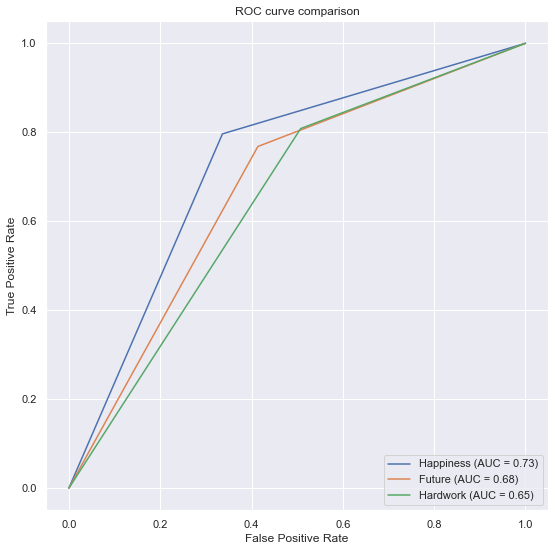

In [6]:
def plot_roc(y_true, y_pred, labels):
    fig, ax = plt.subplots(1, 1, figsize=(9,9))
    for label in labels:
        fpr, tpr, _ = sklearn.metrics.roc_curve(y_true[label], y_pred[label])
        auc = sklearn.metrics.auc(fpr, tpr)
        display = sklearn.metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc, estimator_name=label)
        display.plot(ax=ax)
    
    plt.title("ROC curve comparison")
    plt.savefig("../../results/RandomForest_ROC.pdf")
    plt.show()
    

plot_roc(y_test, y_preds, y_test.columns)

In [7]:
results = pd.read_csv("../../results/model_scores.csv", index_col=0)

if results.Model.isin(["Random Forest"]).any(axis=None)==False:
    for i in y_train.columns:
        
        s = pd.DataFrame(scores[i]).reset_index()
        s["Target"] = i
        s["Model"] = "Random Forest"
        s = s.loc[s.index==1]
        results = pd.concat([results, s], axis=0)
        results = results.drop(["Best Hyperparameters", "index"], axis=1)
    
results

,Best training score,Accuracy,F1 score,AUC,Target,Model
1,0.755712,0.747941,0.775660,0.742803,Happiness,Logistic Regression
1,0.717608,0.714992,0.752504,0.706899,Future,Logistic Regression
1,0.667356,0.669687,0.731773,0.649861,Hardwork,Logistic Regression
1,0.707724,0.668040,0.701260,0.663379,Happiness,KNN
1,0.670031,0.645799,0.700974,0.633656,Future,KNN
1,0.620391,0.620264,0.690396,0.600125,Hardwork,KNN
1,0.745005,0.734761,0.764964,0.729112,Happiness,Random Forest
1,0.707724,0.694399,0.734811,0.686013,Future,Random Forest
1,0.662204,0.662273,0.729551,0.639761,Hardwork,Random Forest
1,0.746859,0.745470,0.772627,0.740663,Happiness,XGBoost


In [8]:
results.to_csv("../../results/model_scores.csv")